In [1]:
import sys
sys.path.insert(0, '/gap-junction-segmentation/code/src')
from pathlib import Path
import os
import re
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
from cc3d import connected_components
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, confusion_matrix
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch import nn
from torchmetrics.classification import (
    BinaryAccuracy,
    BinaryPrecision,
    BinaryRecall,
    BinaryF1Score,
    BinaryJaccardIndex
)
from tqdm import tqdm
from torchvision.transforms.functional import to_tensor
from scipy.ndimage import label

src_path = os.path.abspath(os.path.join(os.getcwd(), "..", "src"))
if src_path not in sys.path:
    sys.path.append(src_path)

#Custom libraries
from utils import * ##import everything
from models import TestDataset, UNet #import custom model and dataset
from entity_detection_2d import GapJunctionEntityDetector2D

In [ ]:
import sys
# Add parent directory to sys.path
parent_dir = '/home/tommytang111/gap-junction-segmentation/code/src'
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)


Number of detected gap junction entities in inference image: 19
Number of detected gap junction entities in ground truth image: 13
[[(np.int64(0), np.int64(332)), (np.int64(0), np.int64(333)), (np.int64(0), np.int64(334)), (np.int64(1), np.int64(331)), (np.int64(1), np.int64(332)), (np.int64(1), np.int64(333)), (np.int64(1), np.int64(334)), (np.int64(1), np.int64(335)), (np.int64(1), np.int64(336)), (np.int64(2), np.int64(330)), (np.int64(2), np.int64(331)), (np.int64(2), np.int64(332)), (np.int64(2), np.int64(333)), (np.int64(2), np.int64(334)), (np.int64(2), np.int64(335)), (np.int64(2), np.int64(336)), (np.int64(3), np.int64(330)), (np.int64(3), np.int64(331)), (np.int64(3), np.int64(332)), (np.int64(3), np.int64(333)), (np.int64(3), np.int64(334)), (np.int64(3), np.int64(335)), (np.int64(3), np.int64(336)), (np.int64(4), np.int64(330)), (np.int64(4), np.int64(331)), (np.int64(4), np.int64(332)), (np.int64(4), np.int64(333)), (np.int64(4), np.int64(334)), (np.int64(4), np.int64(335)

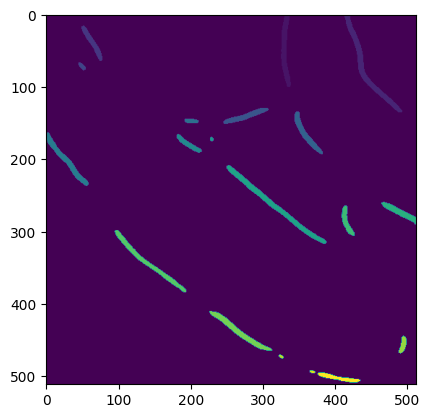

In [2]:
from torchvision.transforms import ToTensor
entity_detector = GapJunctionEntityDetector2D()
##Load in the image

gj_img = cv2.imread("/Users/kirby/Desktop/GJ_data/imgs/SEM_adult_image_export2_s200_part5.png", cv2.IMREAD_GRAYSCALE)
gt_img = cv2.imread("/Users/kirby/Desktop/GJ_data/gts/SEM_adult_image_export2_s200_part5_label.png", cv2.IMREAD_GRAYSCALE)
model = UNet(classes = 1, )  
model_path = "/Users/kirby/Desktop/GJ_models/best_models/unet_base_516imgs_sem_adult_8jkuifab.pt"

if gj_img is None:
    raise ValueError("gj img dne")

if gt_img is None:
    raise ValueError("gj img dne")

# Modify the single_image_inference function to include map_location
pred_img = single_image_inference_kirpa(image=gj_img, model_path=model_path, model=model)


pred_labelled, pred_entities_positions, pred_num_entities =  GapJunctionEntityDetector2D.extract_entities_2d(entity_detector, img=pred_img)
gt_labelled, gt_entities_positions, gt_num_entities =  GapJunctionEntityDetector2D.extract_entities_2d(entity_detector, img=gt_img)

print(f"Number of detected gap junction entities in inference image: {pred_num_entities}")
print(f"Number of detected gap junction entities in ground truth image: {gt_num_entities}")

print(pred_entities_positions)
plt.imshow(pred_labelled)

[(np.int64(0), np.int64(332)), (np.int64(0), np.int64(333)), (np.int64(0), np.int64(334)), (np.int64(1), np.int64(331)), (np.int64(1), np.int64(332)), (np.int64(1), np.int64(333)), (np.int64(1), np.int64(334)), (np.int64(1), np.int64(335)), (np.int64(1), np.int64(336)), (np.int64(2), np.int64(330)), (np.int64(2), np.int64(331)), (np.int64(2), np.int64(332)), (np.int64(2), np.int64(333)), (np.int64(2), np.int64(334)), (np.int64(2), np.int64(335)), (np.int64(2), np.int64(336)), (np.int64(3), np.int64(330)), (np.int64(3), np.int64(331)), (np.int64(3), np.int64(332)), (np.int64(3), np.int64(333)), (np.int64(3), np.int64(334)), (np.int64(3), np.int64(335)), (np.int64(3), np.int64(336)), (np.int64(4), np.int64(330)), (np.int64(4), np.int64(331)), (np.int64(4), np.int64(332)), (np.int64(4), np.int64(333)), (np.int64(4), np.int64(334)), (np.int64(4), np.int64(335)), (np.int64(4), np.int64(336)), (np.int64(5), np.int64(329)), (np.int64(5), np.int64(330)), (np.int64(5), np.int64(331)), (np.int64

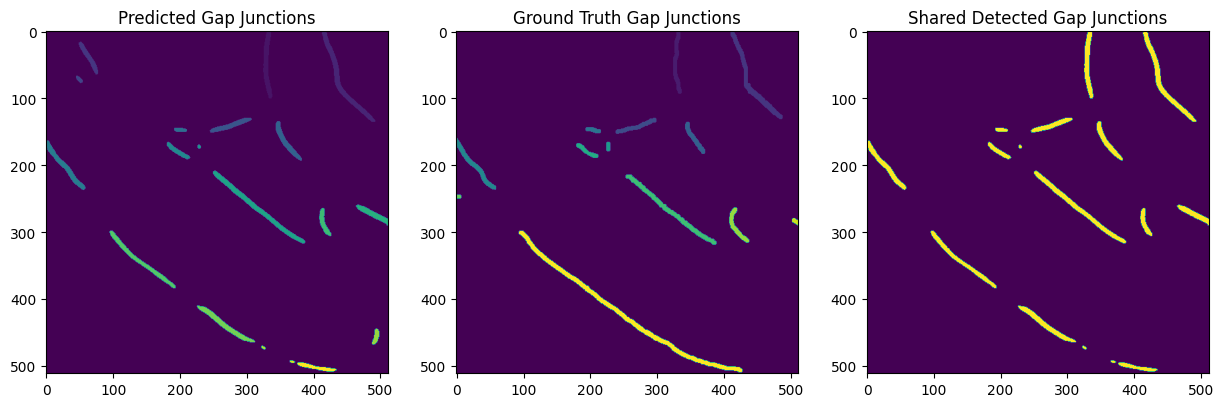

In [3]:
# Get the shared positions and metrics
shared_positions, metrics, shared_entities = entity_detector.entity_metrics_2d(pred_img, gt_img)
print(shared_positions)  # This will show the actual positions
print(f"shared entities:{shared_entities}")

# Calculate metrics
precision = metrics['precision']
recall = metrics['recall']
f1_score = metrics['f1_score']

print(f"Precision: {precision:.4f}\n Recall: {recall:.4f}\n F1 Score: {f1_score:.4f}")

# Visualize the results
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Predicted Gap Junctions")
plt.imshow(pred_labelled)
plt.subplot(1,3,2)
plt.title("Ground Truth Gap Junctions")
plt.imshow(gt_labelled)
plt.subplot(1,3,3)
plt.title("Shared Detected Gap Junctions")

# Create the shared image using the positions
shared_img = np.zeros_like(pred_img)
for pos in shared_positions:
    shared_img[pos[0], pos[1]] = 1
plt.imshow(shared_img)

### Tommy

In [ ]:
#Testing
import cc3d
import numpy as np
#Create 10x10 numpy array with random 0s and 255s
np.random.seed(0)
random_array = np.random.choice([0, 255], size=(10, 10), p=[0.7, 0.3]).astype(np.uint8)
filtered_array = cc3d.dust(random_array, threshold=2, connectivity=8, in_place=False)
entity_array, num_entities = cc3d.connected_components(filtered_array, connectivity=8, return_N=True)
print('Original Array:')
print(random_array)
print()
print('Filtered Array:')
print(filtered_array)
print('Entity Array')
print(entity_array)

Original Array:
[[  0 255   0   0   0   0   0 255 255   0]
 [255   0   0 255   0   0   0 255 255 255]
 [255 255   0 255   0   0   0 255   0   0]
 [  0 255   0   0   0   0   0   0 255   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0 255   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 255   0 255   0]
 [255   0 255   0 255   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 255]
 [  0   0   0 255   0   0   0   0 255   0]]

Filtered Array:
[[  0 255   0   0   0   0   0 255 255   0]
 [255   0   0 255   0   0   0 255 255 255]
 [255 255   0 255   0   0   0 255   0   0]
 [  0 255   0   0   0   0   0   0 255   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 255]
 [  0   0   0   0   0   0   0   0 255   0]]
Entity Array
[[0 1 0 0 0 0 0 2 2 0]
 [1 0 0 3 0 0 0 2 2 2]
 [1 1 0 3 0 0 0 2 0 0]
 [0 1 0 0 0 0 0 0 2 0]


In [ ]:
#Create a point array
np.random.seed(31)
point_array = np.random.choice([0, 1], size=(10, 10), p=[0.95, 0.05]).astype(np.uint8)
print('Point Array:')
print(point_array)

Point Array:
[[0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


In [74]:
from scipy.ndimage import distance_transform_edt

#Convert points to boolean array
points_mask = (point_array > 0)

#Distance transform to distance array using inverse (bitwise NOT) of points mask
dist_to_points = distance_transform_edt(~points_mask)

#Create boolean mask of voxels within 15 units of any point
near_points = dist_to_points <= 2

#Keep only entities that overlap with near_points
#Step 1: Get intersection of near_points and entity voxels (using boolean AND) and keep only those labels
keep_labels = np.unique(entity_array[near_points & (entity_array > 0)])
#Step 2: Filter entity array to keep only labels found in Step 1
filtered_entity_array = np.where(np.isin(entity_array, keep_labels), entity_array, 0) 

print(filtered_entity_array)

[[0 1 0 0 0 0 0 2 2 0]
 [1 0 0 3 0 0 0 2 2 2]
 [1 1 0 3 0 0 0 2 0 0]
 [0 1 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


In [ ]:
from scipy.ndimage import binary_dilation, generate_binary_structure
import time

points = np.zeros([10, 10, 10])
points[5,5,5] = 255
points[1,1,1] = 255
start=time.time()
dilated = binary_dilation(points, structure=generate_binary_structure(3, 3), iterations=1)
end=time.time()
print((end-start)*8000) #Estimate of how long binary dilation takes for 8000 GJ points
np.sum(dilated)


3.6716461181640625


np.int64(54)

In [25]:
start = time.time()
dilated.astype(np.uint8)
end = time.time()
#print(end - start)
dilated

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
import sys
sys.path.insert(0, '/gap-junction-segmentation/code/src')
from src.entity_detection_3d import calculate_metrics_3d